# **Load Libraries**

In [8]:
# Import packages
import pandas as pd
import numpy as np
import rasterio
import earthpy.plot as ep

import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors
%matplotlib inline

from tensorflow.keras.models import load_model

# **Parameters**

In [2]:
N_CLASSES = 5
CLASSES = [1, 2, 3, 4, 5]
PALETTE = ['dodgerblue', 'red', 'yellow', 'forestgreen', 'coral']
CLASSED = ['Pomelo', 'Rambutan', 'Coconut', 'Coconut Int', 'Durian']
IMAGE_PATH = './Data/S2P_band_texture_norm_sample.tif'

# **Load image**

In [ ]:
image = rasterio.open(IMAGE_PATH)
bandNum = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform
shape = (height, width)

print(bandNum)
print(shape)
print(crs)

32
(398, 648)
EPSG:32648


# **Visualization**

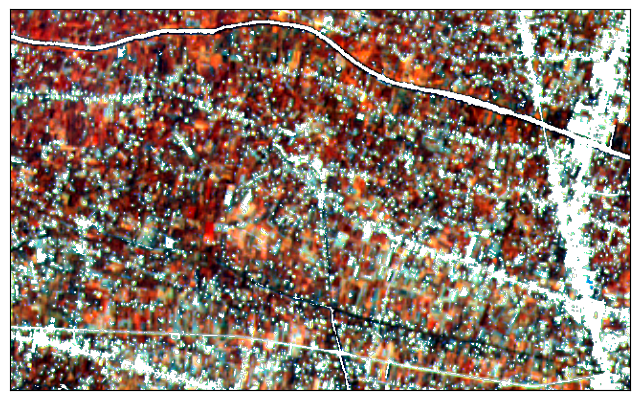

<Axes: >

In [6]:
image_vis = []
for x in [5, 4, 3]:
  image_vis.append(image.read(x))
image_vis = np.stack(image_vis)

plot_size = (8, 8)
ep.plot_rgb(image_vis, figsize=plot_size, stretch=True)

# **Load Trained Model**

In [9]:
# Save the entire model as a `.keras` zip archive.
model = load_model('./trained_cnn_model.keras')

# **Predict image using the trained Model**

63/63 [==============================] - 18s 277ms/step


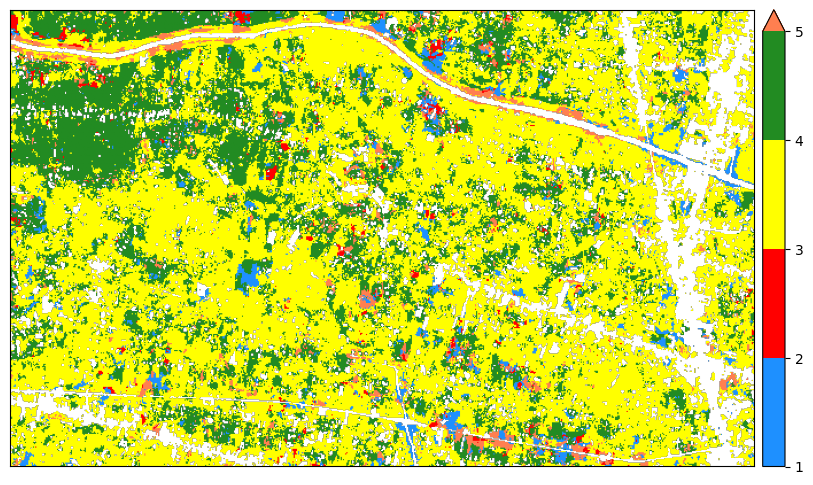

<Axes: >

In [10]:
image_input = []

nbands = 32

# Function to reshape array input
def reshape_input(array):
  shape = array.shape
  return array.reshape(shape[0], shape[1], 1)


for x in range(nbands):
  image_input.append(image.read(x + 1))
image_input = reshape_input(np.stack(image_input).reshape(nbands, -1).T)

# Predict
prediction = model.predict(image_input, batch_size=1024*4)
prediction = np.argmax(prediction, 1)
prediction = prediction.reshape(shape[0], shape[1])

# Visualize
cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')
ep.plot_bands(prediction, cmap=cmap, norm=norm, figsize=(10, 10))

# **Export results**

In [11]:
# Write the NumPy array to a GeoTIFF file
with rasterio.open(IMAGE_PATH) as src:
  profile = src.profile

profile.update(**{
    'count': 1,
    'dtype': prediction.dtype,
    'nodata': -9999
})

print(profile)

with rasterio.open('./Data/S2P_band_texture_norm_sample_classified.tif', 'w', **profile) as dst:
    dst.write(prediction, 1)

print("GeoTIFF file saved successfully!")

{'driver': 'GTiff', 'dtype': dtype('int64'), 'nodata': -9999, 'width': 648, 'height': 398, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 48N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32648"]]'), 'transform': Affine(10.0, 0.0, 642440.0,
       0.0, -10.0, 1139640.0), 'blockxsize': 648, 'blockysize': 1, 'tiled': False, 'interleave': 'pixel'}
GeoTIFF file saved successfully!
